In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib.colors import ListedColormap

def modified_coolwarm_low(low="#1a9850", *, N=256, name="coolgreen"):
    """
    Return a version of 'coolwarm' where the *lower* half fades
    into `low` (instead of blue).

    Parameters
    ----------
    low : str or tuple
        Target low-end colour (e.g. "#1a9850" for green).
    N : int
        Number of discrete samples pulled from the base map (256 by default).
    name : str
        Name given to the resulting colormap object.

    Returns
    -------
    matplotlib.colors.ListedColormap
    """
    base = mpl.cm.get_cmap("coolwarm", N)           # original map, N samples
    colors = base(np.linspace(0, 1, N))             # RGBA array, shape (N,4)
    mid = N // 2                                    # neutral grey index
    lo_rgba = mpl.colors.to_rgba(low)

    # Replace the lower half [0 : mid] with a linear blend: `low` → mid-grey
    t = np.linspace(0, 1, mid + 1)[:, None]         # 0 → 1 from low to centre
    colors[:mid + 1] = (1 - t) * lo_rgba + t * colors[mid]

    return ListedColormap(colors, name=name)

In [2]:
#-------------------------- Standard Imports --------------------------#
%reload_ext autoreload
%autoreload 2
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import acr
import warnings
import pingouin as pg
from scipy.stats import shapiro, normaltest
import os
from pathlib import Path
import numpy as np
import pingouin as pg

warnings.filterwarnings('ignore')
probe_ord = ['NNXr', 'NNXo']
#hue_ord = [NNXR_GRAY, MAIN_COLOR]
from kdephys.utils.main import td
from cmcrameri import cm as scm

#--------------------------------- Import Publication Functions ---------------------------------#
pub_utils = acr.utils.import_publication_functions('/Users/driessen2@ad.wisc.edu/kdriessen/gh_master/PUBLICATION__ACR/pub_utils.py', 'pub_utils')
from pub_utils import *
data_agg = acr.utils.import_publication_functions('/Users/driessen2@ad.wisc.edu/kdriessen/gh_master/PUBLICATION__ACR/data_agg.py', 'data_agg')
from data_agg import *

#--------------------------------- Plotting Setup ---------------------------------#
import pubplots as pp
plt.rcdefaults()
plt.style.use('default')
style_path = "/Users/driessen2@ad.wisc.edu/kdriessen/acr_dev/acr/src/acr/plot_styles/acrvec_labels.mplstyle"
from cmcrameri import cm as scm

In [3]:
import spikeinterface.widgets as sw

In [4]:
nbroot = os.path.join(PAPER_FIGURE_ROOT, 'response_to_review', 'single_unit_sync')
if not os.path.exists(nbroot):
    os.mkdir(nbroot)

In [5]:
sorting_id = 'ebl_cbl_reb'

In [6]:
MAIN_EXP = 'swi'
SUBJECT_TYPE = 'acr'
MAIN_COLOR = ACR_BLUE
subjects, exps = get_subject_list(type=SUBJECT_TYPE, exp=MAIN_EXP)
subjects, exps = remove_subject("ACR_20", subjects, exps)
subjects, exps = remove_subject("ACR_16", subjects, exps)

# STTC

In [7]:
uidxs = {}
uidxs['ACR_31'] = {}
uidxs['ACR_31']['NNXr'] = [5]
uidxs['ACR_34'] = {}
uidxs['ACR_34']['NNXr'] = [10]
uidxs['ACR_19'] = {}
uidxs['ACR_19']['NNXo'] = [12]
uidxs['ACR_23'] = {}
uidxs['ACR_23']['NNXo'] = [3]

In [8]:
rate_types = pl.read_parquet('acr_rate_types.parquet') #join rate types on subject, probe, unit_id
rate_types = rate_types.drop('rate')

In [12]:
df_filts = {}
ans = {}
qms = {}
for subject, exp in zip(subjects, exps):
    print(subject, exp)
    df_raw, qm, an = acr.ms.load_spike_df_with_qm(subject, exp, sorting_id, return_analyzers=True)
    unts = {}
    filt_dfs = []
    qms[subject] = qm
    for probe in ['NNXo', 'NNXr']:
        qm_probe = qm.prb(probe)        
        unts[probe] = acr.ms.select_good_units(qm_probe.to_pandas(), presence_min=0.95, full_mask=False)
        untsin = unts[probe][0]
        if subject in uidxs.keys():
            if probe in uidxs[subject].keys():
                mask = np.isin(untsin, uidxs[subject][probe])
                untsin = untsin[~mask]
        df_probe = df_raw.filter((pl.col('probe') == probe)&(pl.col('unit_id').is_in(untsin)))
        filt_dfs.append(df_probe)
    df = pl.concat(filt_dfs)
    qms[subject] = qms[subject].with_columns(pl.lit(subject).alias('subject'))
    rt_sub = rate_types.filter(pl.col('subject')==subject)
    df = df.with_columns(pl.lit(subject).alias('subject'))
    df = df.join(rt_sub, on=['subject', 'probe', 'unit_id'], how='left')
    #df = df.filter(pl.col('cell_type')=='pyr')
    df_filts[subject] = df
    ans[subject] = an

ACR_17 swi
ACR_18 swi
ACR_19 swi2
ACR_23 swi2
ACR_31 swi2
ACR_33 swi
ACR_34 swi


In [13]:
df_counts = []
for subject in df_filts.keys():
    dc = df_filts[subject].group_by('probe').agg(pl.col('unit_id').unique().count())
    dc = dc.to_pandas()
    dc['subject'] = subject
    dc['sub_type'] = SUBJECT_TYPE
    df_counts.append(dc)
df_count = pd.concat(df_counts)
df_count.to_parquet(f'{SUBJECT_TYPE}_dfcounts.parquet')

In [10]:
count_dfs = []
for subject in qms.keys():
    cdf = qms[subject].filter(pl.col('presence_ratio')>0.95).group_by('probe').count()
    count_dfs.append(cdf)
counts = pl.concat(count_dfs)
counts.write_parquet(f'counts_{SUBJECT_TYPE}.parquet')

In [11]:
concat_qm = pl.concat([qms[subject] for subject in subjects])
concat_qm.write_parquet(f'all_qm_{SUBJECT_TYPE}.parquet')

In [14]:
cond_dfs = {}
spike_trains = {}
sttcs = {}
for subject in df_filts.keys():
    cond_dfs[subject] = {}
    times = [
        (0, 3600),
        (3600, 7200),
        (7200, 10800)
    ]
    for tt, cond in zip(times, ['early_bl', 'circ_bl', 'rebound']):
        cond_df = df_filts[subject].filter((pl.col('time')>=tt[0])&(pl.col('time')<tt[1]))
        dftimes = cond_df['time'].to_numpy()
        times_rel = dftimes - tt[0]
        cond_df = cond_df.with_columns(pl.lit(times_rel).alias('time_rel'))
        cond_dfs[subject][cond] = cond_df
for subject in df_filts.keys():
    spike_trains[subject] = {}
    for cond in cond_dfs[subject]:
        spike_trains[subject][cond] = {}
        for probe in ['NNXo', 'NNXr']:
            spike_trains[subject][cond][probe] = []
            uids = cond_dfs[subject][cond].prb(probe)['unit_id'].unique().to_numpy()
            uids = np.sort(uids)
            for uid in uids:
                spike_trains[subject][cond][probe].append(cond_dfs[subject][cond].prb(probe).filter(pl.col('unit_id') == uid)['time_rel'].to_numpy())
for subject in spike_trains.keys():
    sttcs[subject] = {}
    for cond in spike_trains[subject].keys():
        sttcs[subject][cond] = {}
        for probe in spike_trains[subject][cond].keys():
            sttcs[subject][cond][probe] = acr.sync.sttc_matrix_fast(spike_trains[subject][cond][probe], 0, 3600, .005)

# Subject - Level STTC

In [15]:
reb_rels_hom = {}
for subject in spike_trains.keys():
    reb_rels_hom[subject] = {}
    for probe in ['NNXr', 'NNXo']:
        hom = sttcs[subject]['early_bl'][probe] - sttcs[subject]['circ_bl'][probe]
        mask = hom > 0.0
        # where mask is false, set hom to nan
        hom[~mask] = np.nan
        
        eps = 1e-6
        cbl_mtx = np.arctanh(np.clip(sttcs[subject]['circ_bl'][probe], -1+eps, 1-eps))
        reb_mtx = np.arctanh(np.clip(sttcs[subject]['rebound'][probe], -1+eps, 1-eps))
        
        reb_rel = reb_mtx - cbl_mtx
        reb_rel[~mask] = np.nan
        reb_rels_hom[subject][probe] = reb_rel
nnxo = np.array([np.nanmean(reb_rels_hom[subject]['NNXo']) for subject in reb_rels_hom.keys()])
nnxr = np.array([np.nanmean(reb_rels_hom[subject]['NNXr']) for subject in reb_rels_hom.keys()])

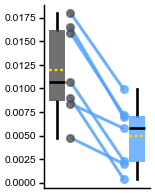

shapiro_p-value: 0.009249161814058748
d,agostino_p-value: nan
hedges g: 1.5281345354025468


,W-val,alternative,p-val,RBC,CLES
Wilcoxon,0.0,two-sided,0.015625,1.0,0.877551


In [21]:
figname = f'{SUBJECT_TYPE}-sttc-homeo-units'
fig_p = f'{figname}.svg'
with pp.destination('figma', style=style_path):
    f, ax = acr.plots.gen_paired_boxplot(nnxr, nnxo, colors=[NNXR_GRAY, MAIN_COLOR], fsize=pp.scale(1.15, 1.4))
    ax.set_xticklabels([])
    plt.show()
    f.savefig(os.path.join(nbroot, fig_p), transparent=True, bbox_inches='tight')
diffs = nnxr - nnxo
shap_stat, shap_p = shapiro(diffs) # test the paired differences for normality
agostino_stat, agostino_p = normaltest(diffs) # test the paired differences for normality
print(f'shapiro_p-value: {shap_p}')
print(f'd,agostino_p-value: {agostino_p}')

stats = pg.ttest(nnxr, nnxo, paired=True)
stats = pg.wilcoxon(nnxr, nnxo)
hg = pg.compute_effsize(nnxr, nnxo, paired=True, eftype='hedges')
print(f'hedges g: {hg}')

#r = acr.stats.calculate_wilx_r(stats['W-val'][0], len(nnxr))
# ==== Write Stats Results ====
acr.stats.write_stats_result(
    figname, 
    'paired_ttest',
    test_statistic=stats['W-val'][0],
    p_value=stats['p-val'][0],
    effect_size_method='RBC',
    effect_size=stats['RBC'][0],
    review=True,
)

## ===== Write Source Data =====
source_data = pd.DataFrame({'contra_control': nnxr, 'off_induction': nnxo, 'subject': np.arange(len(nnxr))})
write_source_data(source_data, figname)
stats

In [22]:
reb_rels_fixed = {}
for subject in spike_trains.keys():
    reb_rels_fixed[subject] = {}
    for probe in ['NNXr', 'NNXo']:
        hom = sttcs[subject]['early_bl'][probe] - sttcs[subject]['circ_bl'][probe]
        mask = hom <= 0.0
        # where mask is false, set hom to nan
        hom[~mask] = np.nan
        
        eps = 1e-6
        cbl_mtx = np.arctanh(np.clip(sttcs[subject]['circ_bl'][probe], -1+eps, 1-eps))
        reb_mtx = np.arctanh(np.clip(sttcs[subject]['rebound'][probe], -1+eps, 1-eps))
        
        reb_rel = reb_mtx - cbl_mtx
        reb_rel[~mask] = np.nan
        reb_rels_fixed[subject][probe] = reb_rel
nnxo = np.array([np.nanmean(reb_rels_fixed[subject]['NNXo']) for subject in reb_rels_fixed.keys()])
nnxr = np.array([np.nanmean(reb_rels_fixed[subject]['NNXr']) for subject in reb_rels_fixed.keys()])

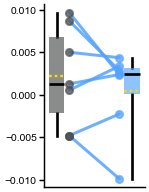

shapiro_p-value: 0.22845707212922112
d,agostino_p-value: nan
hedges g: 0.3031108632122079


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.105393,6,two-sided,0.311332,"[-0.0, 0.01]",0.323778,0.564,0.112452


In [24]:
figname = f'{SUBJECT_TYPE}-sttc-fixed-units'
fig_p = f'{figname}.svg'
with pp.destination('figma', style=style_path):
    f, ax = acr.plots.gen_paired_boxplot(nnxr, nnxo, colors=[NNXR_GRAY, MAIN_COLOR], fsize=pp.scale(1.15, 1.4), alphas=[0.65, 0.65])
    ax.set_xticklabels([])
    plt.show()
    f.savefig(os.path.join(nbroot, fig_p), transparent=True, bbox_inches='tight')
diffs = nnxr - nnxo
shap_stat, shap_p = shapiro(diffs) # test the paired differences for normality
agostino_stat, agostino_p = normaltest(diffs) # test the paired differences for normality
print(f'shapiro_p-value: {shap_p}')
print(f'd,agostino_p-value: {agostino_p}')

stats = pg.ttest(nnxr, nnxo, paired=True)
# stats = pg.wilcoxon(nnxr, nnxo)
hg = pg.compute_effsize(nnxr, nnxo, paired=True, eftype='hedges')
print(f'hedges g: {hg}')

#r = acr.stats.calculate_wilx_r(stats['W-val'][0], len(nnxr))
# ==== Write Stats Results ====
acr.stats.write_stats_result(
    figname, 
    'paired_ttest',
    test_statistic=stats['T'][0],
    p_value=stats['p-val'][0],
    effect_size_method='g',
    effect_size=hg,
    review=True,
)

## ===== Write Source Data =====
source_data = pd.DataFrame({'contra_control': nnxr, 'off_induction': nnxo, 'subject': np.arange(len(nnxr))})
write_source_data(source_data, figname)
stats


# Single Unit-Level STTC

In [25]:
cond_dfs = {}
spike_trains = {}
sttcs = {}
for subject in df_filts.keys():
    cond_dfs[subject] = {}
    times = [
        (0, 3600),
        (3600, 7200),
        (7200, 10800)
    ]
    for tt, cond in zip(times, ['early_bl', 'circ_bl', 'rebound']):
        cond_df = df_filts[subject].filter((pl.col('time')>=tt[0])&(pl.col('time')<tt[1]))
        dftimes = cond_df['time'].to_numpy()
        times_rel = dftimes - tt[0]
        cond_df = cond_df.with_columns(pl.lit(times_rel).alias('time_rel'))
        cond_dfs[subject][cond] = cond_df
for subject in df_filts.keys():
    spike_trains[subject] = {}
    for cond in cond_dfs[subject]:
        spike_trains[subject][cond] = {}
        for probe in ['NNXo', 'NNXr']:
            spike_trains[subject][cond][probe] = []
            uids = cond_dfs[subject][cond].prb(probe)['unit_id'].unique().to_numpy()
            uids = np.sort(uids)
            for uid in uids:
                spike_trains[subject][cond][probe].append(cond_dfs[subject][cond].prb(probe).filter(pl.col('unit_id') == uid)['time_rel'].to_numpy())
for subject in spike_trains.keys():
    sttcs[subject] = {}
    for cond in spike_trains[subject].keys():
        sttcs[subject][cond] = {}
        for probe in spike_trains[subject][cond].keys():
            sttcs[subject][cond][probe] = acr.sync.sttc_matrix_fast(spike_trains[subject][cond][probe], 0, 3600, .005)

In [26]:
# Homeostatically regulated unit pairs
ubu_hom = {}
ubudf_hom = {}
ubudf_hom['NNXo'] = []
ubudf_hom['NNXr'] = []
for subject in spike_trains.keys():
    ubu_hom[subject] = {}
    for probe in ['NNXo', 'NNXr']:
        hom = sttcs[subject]['early_bl'][probe] - sttcs[subject]['circ_bl'][probe]
        mask = hom > 0.0
        ebl = sttcs[subject]['early_bl'][probe]
        cbl = sttcs[subject]['circ_bl'][probe]
        reb = sttcs[subject]['rebound'][probe]
        ebl[~mask] = np.nan
        cbl[~mask] = np.nan
        reb[~mask] = np.nan
        cbl_df = acr.stats.get_positions_and_values_df(cbl, 'sttc_late', subject)
        reb_df = acr.stats.get_positions_and_values_df(reb, 'sttc_rebound', subject)
        reb_df = reb_df.merge(cbl_df, on=['mouse', 'unit_i', 'unit_j'], how='inner')
        reb_df['probe'] = probe
        ubudf_hom[probe].append(reb_df)
ubudf_hom['NNXo'] = pd.concat(ubudf_hom['NNXo'])
ubudf_hom['NNXr'] = pd.concat(ubudf_hom['NNXr'])
main_ubudf_hom = pd.concat(ubudf_hom.values())
main_ubudf_hom['probe'] = main_ubudf_hom['probe'].replace({'NNXo': 'optrode', 'NNXr': 'contra'})
dz = acr.stats.fisher_z(main_ubudf_hom["sttc_rebound"].to_numpy()) - acr.stats.fisher_z(main_ubudf_hom["sttc_late"].to_numpy())
main_ubudf_hom["dz"] = dz

In [19]:
out, idata = acr.stats.pooled_dyadic_probe_effect_pymc(main_ubudf_hom)

Output()

14-Feb-26 13:34:16 | ERROR | There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


In [27]:
main_ubudf_hom.to_csv('dfacr.csv', index=False)

In [28]:
cond_dfs = {}
spike_trains = {}
sttcs = {}
for subject in df_filts.keys():
    cond_dfs[subject] = {}
    times = [
        (0, 3600),
        (3600, 7200),
        (7200, 10800)
    ]
    for tt, cond in zip(times, ['early_bl', 'circ_bl', 'rebound']):
        cond_df = df_filts[subject].filter((pl.col('time')>=tt[0])&(pl.col('time')<tt[1]))
        dftimes = cond_df['time'].to_numpy()
        times_rel = dftimes - tt[0]
        cond_df = cond_df.with_columns(pl.lit(times_rel).alias('time_rel'))
        cond_dfs[subject][cond] = cond_df
for subject in df_filts.keys():
    spike_trains[subject] = {}
    for cond in cond_dfs[subject]:
        spike_trains[subject][cond] = {}
        for probe in ['NNXo', 'NNXr']:
            spike_trains[subject][cond][probe] = []
            uids = cond_dfs[subject][cond].prb(probe)['unit_id'].unique().to_numpy()
            uids = np.sort(uids)
            for uid in uids:
                spike_trains[subject][cond][probe].append(cond_dfs[subject][cond].prb(probe).filter(pl.col('unit_id') == uid)['time_rel'].to_numpy())
for subject in spike_trains.keys():
    sttcs[subject] = {}
    for cond in spike_trains[subject].keys():
        sttcs[subject][cond] = {}
        for probe in spike_trains[subject][cond].keys():
            sttcs[subject][cond][probe] = acr.sync.sttc_matrix_fast(spike_trains[subject][cond][probe], 0, 3600, .005)

In [29]:
# FIXED unit pairs
ubu_fix = {}
ubudf_fix = {}
ubudf_fix['NNXo'] = []
ubudf_fix['NNXr'] = []
for subject in spike_trains.keys():
    ubu_fix[subject] = {}
    for probe in ['NNXo', 'NNXr']:
        print(subject, probe)
        hom = sttcs[subject]['early_bl'][probe] - sttcs[subject]['circ_bl'][probe]
        mask = hom <= 0.0
        ebl = sttcs[subject]['early_bl'][probe]
        cbl = sttcs[subject]['circ_bl'][probe]
        reb = sttcs[subject]['rebound'][probe]
        ebl[~mask] = np.nan
        cbl[~mask] = np.nan
        reb[~mask] = np.nan
        cbl_df = acr.stats.get_positions_and_values_df(cbl, 'sttc_late', subject)
        reb_df = acr.stats.get_positions_and_values_df(reb, 'sttc_rebound', subject)
        reb_df = reb_df.merge(cbl_df, on=['mouse', 'unit_i', 'unit_j'], how='inner')
        reb_df['probe'] = probe
        ubudf_fix[probe].append(reb_df)
ubudf_fix['NNXo'] = pd.concat(ubudf_fix['NNXo'])
ubudf_fix['NNXr'] = pd.concat(ubudf_fix['NNXr'])
main_ubudf_fix = pd.concat(ubudf_fix.values())
main_ubudf_fix['probe'] = main_ubudf_fix['probe'].replace({'NNXo': 'optrode', 'NNXr': 'contra'})
dz = acr.stats.fisher_z(main_ubudf_fix["sttc_rebound"].to_numpy()) - acr.stats.fisher_z(main_ubudf_fix["sttc_late"].to_numpy())
main_ubudf_fix["dz"] = dz

ACR_17 NNXo
ACR_17 NNXr
ACR_18 NNXo
ACR_18 NNXr
ACR_19 NNXo
ACR_19 NNXr
ACR_23 NNXo
ACR_23 NNXr
ACR_31 NNXo
ACR_31 NNXr
ACR_33 NNXo
ACR_33 NNXr
ACR_34 NNXo
ACR_34 NNXr


In [30]:
main_ubudf_fix.to_csv('dfacr_fix.csv', index=False)

In [23]:
out_fix, idata_fix = acr.stats.pooled_dyadic_probe_effect_pymc(main_ubudf_fix)

Output()

14-Feb-26 13:35:58 | ERROR | There were 21 divergences after tuning. Increase `target_accept` or reparameterize.


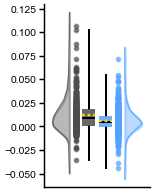

In [31]:
fig_name = f'{SUBJECT_TYPE}-sttc-ALL-homeo_units'
fig_path = os.path.join(nbroot, f'{fig_name}.svg')
with pp.destination('figma', style=style_path):
    f, ax = plt.subplots(1, 1, figsize=pp.scale(1.15, 1.4))
    op_dz = main_ubudf_hom.loc[main_ubudf_hom['probe'] == 'optrode']['dz'].to_numpy()
    cr_dz = main_ubudf_hom.loc[main_ubudf_hom['probe'] == 'contra']['dz'].to_numpy()

    op_mean = np.mean(op_dz)
    cr_mean = np.mean(cr_dz)
    op_std = np.std(op_dz)
    cr_std = np.std(cr_dz)

    #plot the mean as a point with std error bars
    acr.plots.add_boxplot(ax, data=cr_dz, positions=[0.46], color=NNXR_GRAY)
    acr.plots.add_boxplot(ax, data=op_dz, positions=[0.54], color=MAIN_COLOR)
    acr.plots.add_data_points(ax, data=cr_dz, x_pos=0.4, color=NNXR_GRAY, s=30, alpha=0.6)
    acr.plots.add_data_points(ax, data=op_dz, x_pos=0.6, color=MAIN_COLOR, s=30, alpha=0.6)
    
    # add kde-style density plot for cr_dz at x=0.35
    acr.plots.add_vertical_kde(ax, data=cr_dz, x_pos=0.37, color=NNXR_GRAY, width=0.08, alpha=0.4)
    # add kde-style density plot for op_dz at x=0.65
    acr.plots.add_vertical_kde(ax, data=op_dz, x_pos=0.63, color=MAIN_COLOR, width=0.08, alpha=0.4, flip=True)

    ax.set_xlim(0.25, 0.75)
    #ax.set_ylim(-.07, 0.19)
    ax.set_xticklabels([])
    #ax.set_yticklabels([])
    plt.show()
    f.savefig(fig_path, transparent=True, bbox_inches='tight')

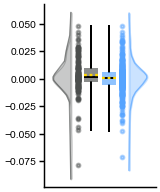

In [32]:
fig_name = f'{SUBJECT_TYPE}-sttc-ALL-FIX_units'
fig_path = os.path.join(nbroot, f'{fig_name}.svg')
with pp.destination('figma', style=style_path):
    f, ax = plt.subplots(1, 1, figsize=pp.scale(1.15, 1.4))
    op_dz = main_ubudf_fix.loc[main_ubudf_fix['probe'] == 'optrode']['dz'].to_numpy()
    cr_dz = main_ubudf_fix.loc[main_ubudf_fix['probe'] == 'contra']['dz'].to_numpy()

    op_mean = np.mean(op_dz)
    cr_mean = np.mean(cr_dz)
    op_std = np.std(op_dz)
    cr_std = np.std(cr_dz)

    #plot the mean as a point with std error bars
    acr.plots.add_boxplot(ax, data=cr_dz, positions=[0.46], color=NNXR_GRAY, alpha=0.65)
    acr.plots.add_boxplot(ax, data=op_dz, positions=[0.54], color=MAIN_COLOR, alpha=0.65)
    acr.plots.add_data_points(ax, data=cr_dz, x_pos=0.4, color=NNXR_GRAY, s=30, alpha=0.45)
    acr.plots.add_data_points(ax, data=op_dz, x_pos=0.6, color=MAIN_COLOR, s=30, alpha=0.45)
    
    # add kde-style density plot for cr_dz at x=0.35
    acr.plots.add_vertical_kde(ax, data=cr_dz, x_pos=0.37, color=NNXR_GRAY, width=0.08, alpha=0.3)
    # add kde-style density plot for op_dz at x=0.65
    acr.plots.add_vertical_kde(ax, data=op_dz, x_pos=0.63, color=MAIN_COLOR, width=0.08, alpha=0.3, flip=True)

    ax.set_xlim(0.25, 0.75)
    #ax.set_ylim(-.07, 0.19)
    ax.set_xticklabels([])
    #ax.set_yticklabels([])
    plt.show()
    f.savefig(fig_path, transparent=True, bbox_inches='tight')

# Check FR

In [11]:
dfs_labelled = []
for subject in df_filts.keys():
    df = df_filts[subject]
    df = df.with_columns(pl.lit(subject).alias('subject'))
    dfs_labelled.append(df)
full_df = pl.concat(dfs_labelled)

In [18]:
frdf = full_df.group_by(['subject','condition', 'probe', 'unit_id']).agg(pl.count())
frdf = frdf.with_columns((pl.col('count')/3600).alias('fr'))

In [19]:
frdf = frdf.sort(['subject', 'condition', 'probe', 'unit_id'])
frdf = frdf.pivot(index=['subject', 'unit_id', 'probe'], columns='condition', values='fr')

In [20]:
frdf = frdf.with_columns((pl.col('circ-bl')/pl.col('early-bl')).alias('reb_rel_fr'))

In [21]:
frmeans = frdf.group_by(['subject', 'probe']).agg(pl.mean('reb_rel_fr')).sort(['subject', 'probe'])

# All subject Vis

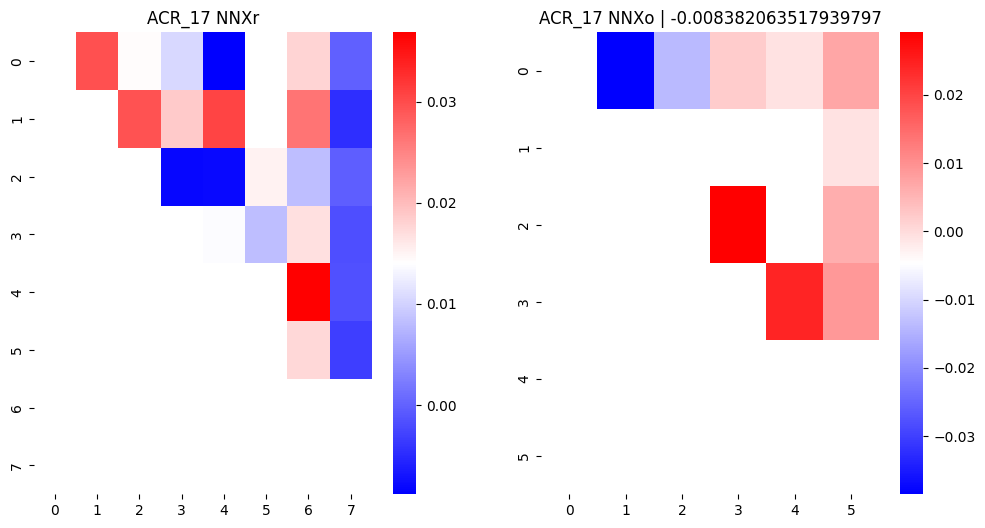

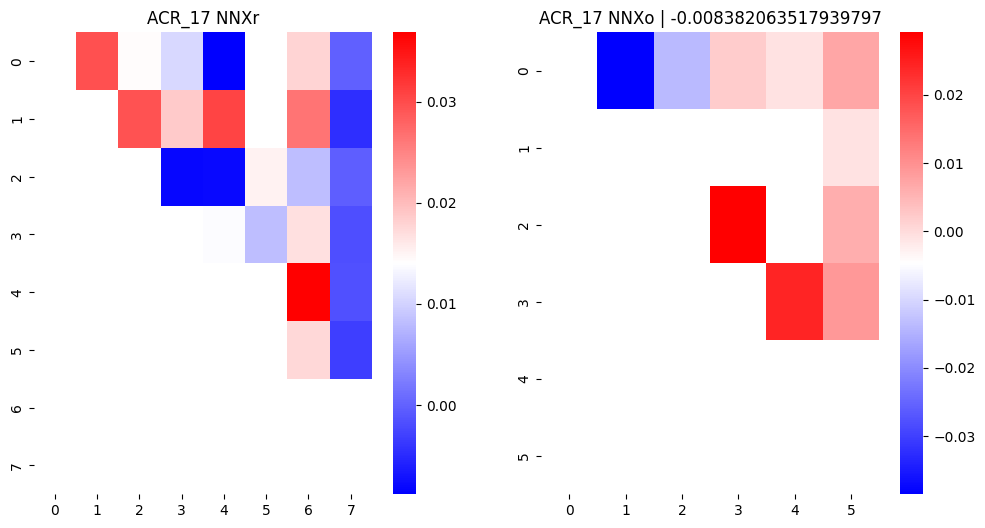

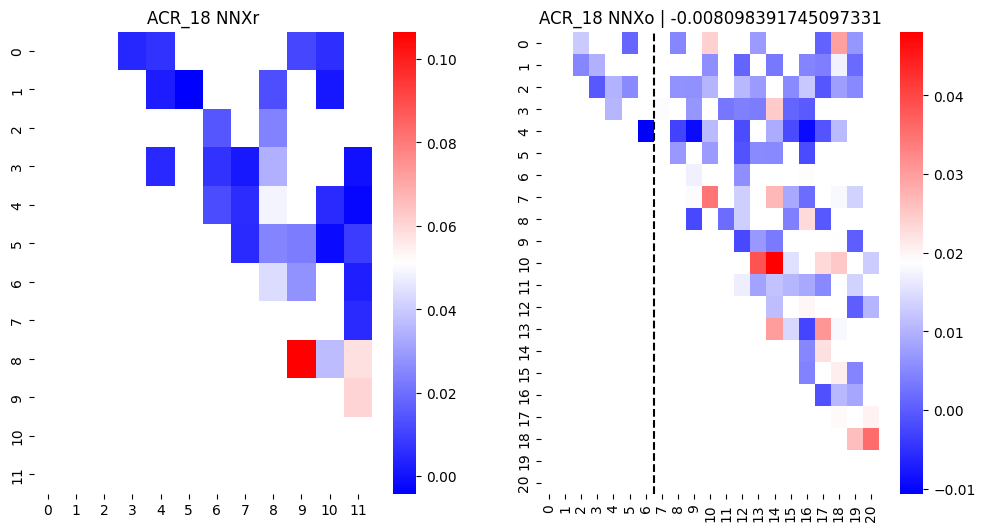

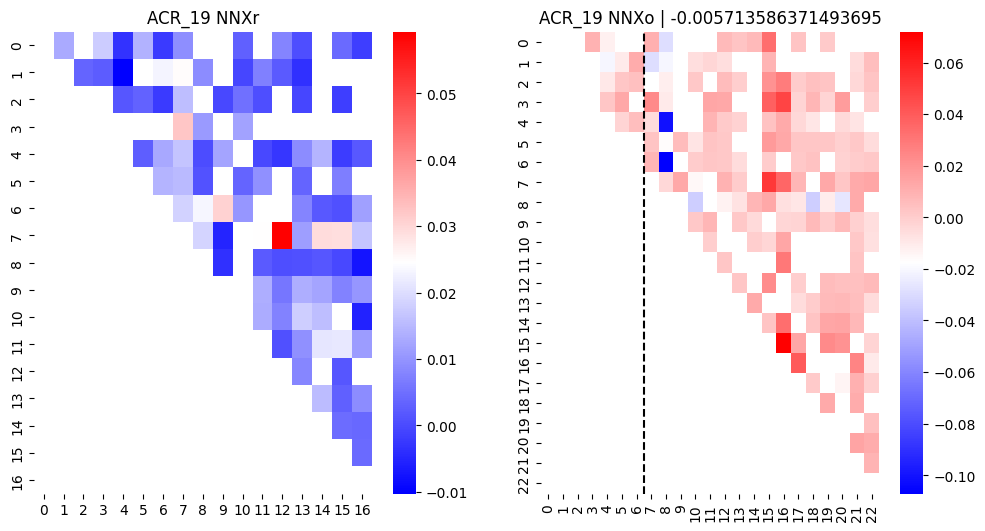

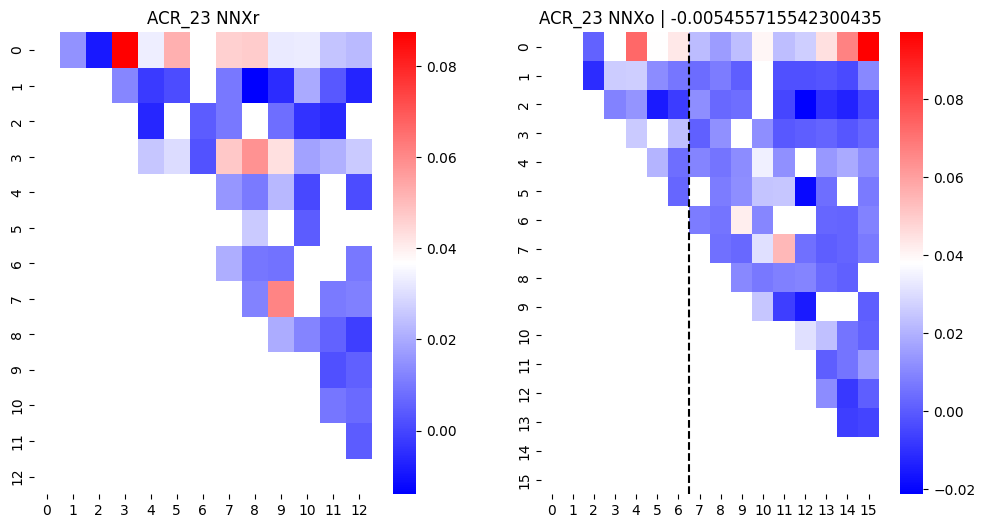

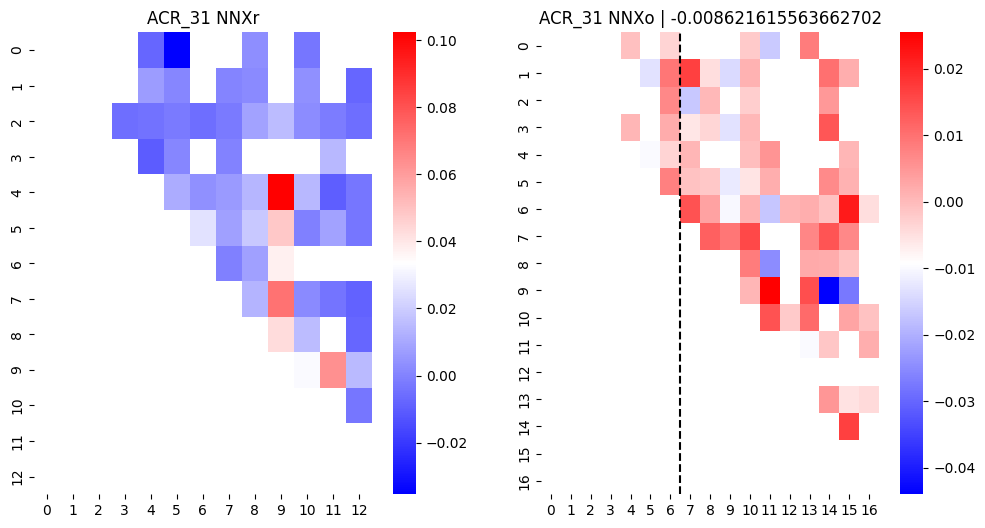

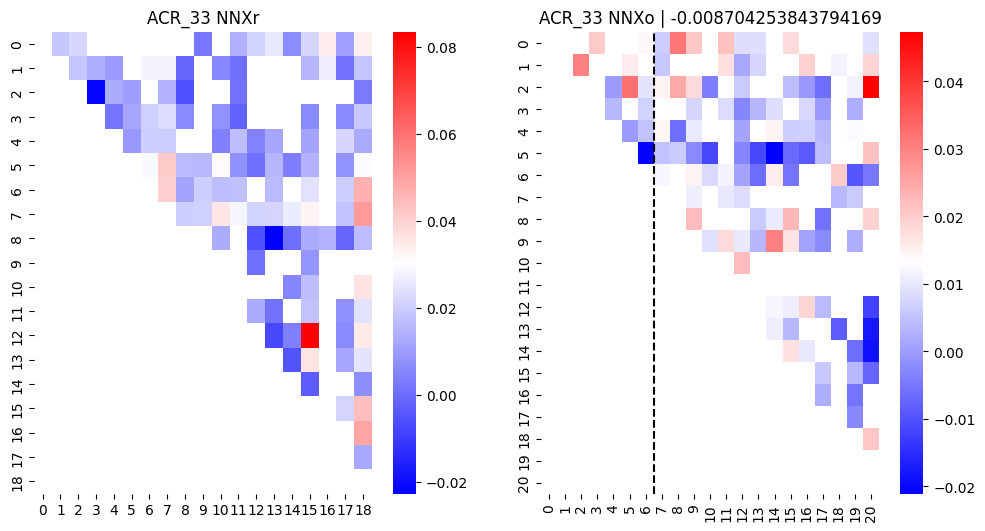

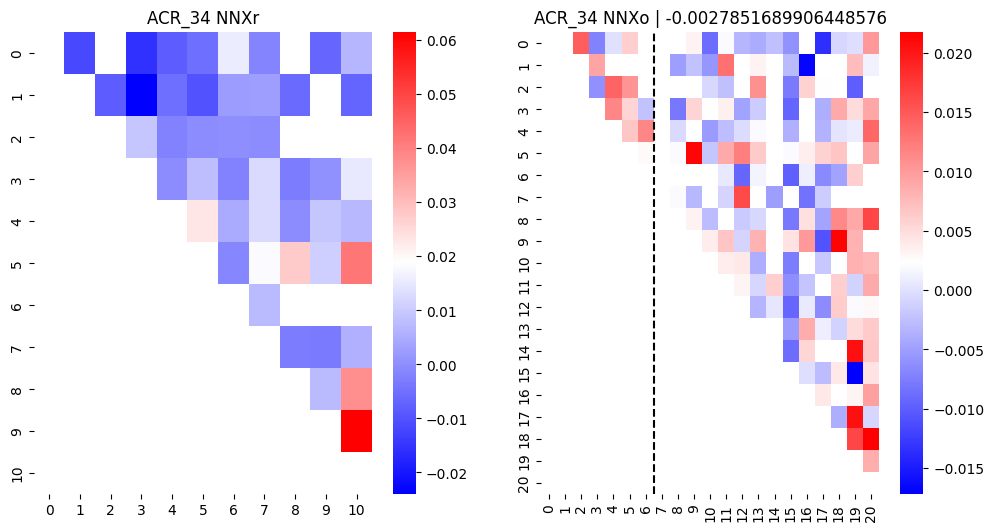

In [60]:
for subject in reb_rels_hom.keys():
    relrel = np.nanmean(reb_rels_hom[subject]['NNXo']) - np.nanmean(reb_rels_hom[subject]['NNXr'])
    f, ax = plt.subplots(1, 2, figsize=(12, 6))
    sns.heatmap(reb_rels_hom[subject]['NNXr'], cmap='bwr', ax=ax[0])
    sns.heatmap(reb_rels_hom[subject]['NNXo'], cmap='bwr', ax=ax[1])
    ax[0].set_title(f'{subject} NNXr')
    ax[1].set_title(f'{subject} NNXo | {relrel}')
    ax[1].axvline(7, color='k', linestyle='--')
    plt.show()

# Relative to global_mua - ON/OFF

In [ ]:
bindfs = [] 
oodfs = {}
for subject, exp in zip(subjects, exps):
        print(subject, exp)
        if subject in bindfs:
                oodf = load_bindf_with_hybrid_format(subject, exp)
        else:
                oodf = compute_hybrid_off_df(subject, exp, chan_threshold=12)
        oodf = acr.oo_utils.enhance_oodf(oodf, full_hyps[subject], hyp_dicts[subject])
        oodfs[subject] = oodf
full_oodf = pl.concat(oodfs.values())
off_means = full_oodf.group_by(['subject', 'probe', 'condition']).agg(pl.col('duration_rel').mean())

ACR_25 swi
ACR_26 swi
ACR_29 swi
ACR_30 swi2
ACR_35 swi
ACR_37 swi2
ACR_39 swi
ACR_40 swi
ACR_41 swi
ACR_44 swi


In [270]:
oowps = {}
for subject, exp in zip(subjects, exps):
        print(subject, exp)
        oodf = load_base_oodf(subject, exp)
        oodf = oodf.offs()
        oodf = acr.oo_utils.enhance_oodf(oodf, full_hyps[subject], hyp_dicts[subject])
        oowps[subject] = oodf
full_oodf = pl.concat(oowps.values())
off_means = full_oodf.group_by(['subject', 'probe', 'condition']).agg(pl.col('duration_rel').mean())

ACR_25 swi
ACR_26 swi
ACR_29 swi
ACR_30 swi2
ACR_35 swi
ACR_37 swi2
ACR_39 swi
ACR_40 swi
ACR_41 swi
ACR_44 swi


In [256]:
subject_dataframes = {}
for subject, exp in zip(subjects, exps):
    if subject == 'ACR_16':
        continue
    print(subject, exp)
    hd = hyp_dicts[subject]
    df_raw, qm, an = acr.ms.load_spike_df_with_qm(subject, exp, sorting_id, return_analyzers=True)
    # Filter at least on presence ratio
    unts = {}
    filt_dfs = []
    for probe in ['NNXo', 'NNXr']:
        qm_probe = qm.prb(probe)
        unts[probe] = acr.ms.select_good_units(qm_probe.to_pandas(), presence_min=0.8, full_mask=False)
        df_probe = df_raw.filter((pl.col('probe') == probe)&(pl.col('unit_id').is_in(unts[probe][0])))
        filt_dfs.append(df_probe)
    df = pl.concat(filt_dfs)
    circ_bl = hd['circ_bl']
    rebound = hd['rebound']
    circ_bl_rec, _t = acr.utils.get_rec_from_dt(subject, circ_bl['start_time'].iloc[0])
    rebound_rec, _t = acr.utils.get_rec_from_dt(subject, rebound['start_time'].iloc[0])
    subinf = acr.info_pipeline.subject_info_section(subject, 'rec_times')
    circ_bl_rec_start = pd.Timestamp(subinf[circ_bl_rec]['start'])
    rebound_rec_start = pd.Timestamp(subinf[rebound_rec]['start'])
    circ_bl_bout_starts = circ_bl['start_time']
    circ_bl_bout_ends = circ_bl['end_time']
    cbl_starts = np.array([(circ_bl_bout_starts[i] - circ_bl_rec_start).total_seconds() for i in range(len(circ_bl_bout_starts))])
    cbl_ends = np.array([(circ_bl_bout_ends[i] - circ_bl_rec_start).total_seconds() for i in range(len(circ_bl_bout_ends))])
    rebound_bout_starts = rebound['start_time']
    rebound_bout_ends = rebound['end_time']
    rb_starts = np.array([(rebound_bout_starts[i] - rebound_rec_start).total_seconds() for i in range(len(rebound_bout_starts))])
    rb_ends = np.array([(rebound_bout_ends[i] - rebound_rec_start).total_seconds() for i in range(len(rebound_bout_ends))])
    epocs_final = {}
    

    cbl_durs = cbl_ends-cbl_starts
    borders = [0]
    for i in range(len(cbl_durs)):
        borders.append(borders[-1]+cbl_durs[i])
    epocs_final['circ-bl'] = []
    for i in range(len(borders)-1):
        epocs_final['circ-bl'].append((borders[i], borders[i+1]))

    rb_durs = rb_ends-rb_starts
    borders = [0]
    for i in range(len(rb_durs)):
        borders.append(borders[-1]+rb_durs[i])
    epocs_final['rebound'] = []
    for i in range(len(borders)-1):
        epocs_final['rebound'].append((borders[i], borders[i+1]))
    reb_df = df.cdn('rebound').sort('time')
    circ_df = df.cdn('circ-bl').sort('time')
    circ_bl_times = circ_df['time'].to_numpy()
    reb_times = reb_df['time'].to_numpy()
    reb_times = reb_times - 3600
    # get the datetime index to reb_df
    indices = [np.searchsorted(reb_times, epocs_final['rebound'][i][1]) for i in range(len(epocs_final['rebound']))]
    current = 0
    epoc_arrays = []
    for i, ix in enumerate(indices):
        epoc_array = reb_times[current:ix]
        epoc_array_rel = epoc_array - epocs_final['rebound'][i][0]
        epoc_arrays.append(epoc_array_rel)
        current = ix
    dt_arrs = []
    epoc_starts = hd['rebound']['start_time']
    for arr, start in zip(epoc_arrays, epoc_starts):
        td_arr = pd.to_timedelta(arr, unit='s')
        dt_arr = start + td_arr
        dt_arrs.append(dt_arr)
    full_dt = np.concat(dt_arrs)
    reb_df = reb_df.with_columns(pl.lit(full_dt).alias('datetime'))
    # get the datetime index to circ_df
    indices = [np.searchsorted(circ_bl_times, epocs_final['circ-bl'][i][1]) for i in range(len(epocs_final['circ-bl']))]
    current = 0
    epoc_arrays = []
    for i, ix in enumerate(indices):
        epoc_array = circ_bl_times[current:ix]
        epoc_array_rel = epoc_array - epocs_final['circ-bl'][i][0]
        epoc_arrays.append(epoc_array_rel)
        current = ix
    dt_arrs = []
    epoc_starts = hd['circ_bl']['start_time']
    for arr, start in zip(epoc_arrays, epoc_starts):
        td_arr = pd.to_timedelta(arr, unit='s')
        dt_arr = start + td_arr
        dt_arrs.append(dt_arr)
    full_dt = np.concat(dt_arrs)
    circ_df = circ_df.with_columns(pl.lit(full_dt).alias('datetime'))
    subject_dataframes[subject] = pl.concat([circ_df, reb_df])

ACR_25 swi
ACR_26 swi
ACR_29 swi
ACR_30 swi2
ACR_35 swi
ACR_37 swi2
ACR_39 swi
ACR_40 swi
ACR_41 swi
ACR_44 swi


In [274]:
final_distances = {}
conds = ['circ-bl', 'rebound']
probes = ['NNXo', 'NNXr']
for subject in subjects:
    final_distances[subject] = {}
    for cond in conds:
        if cond == 'circ-bl':
            old_cond = 'circ_bl'
        else:
            old_cond = 'rebound'
        final_distances[subject][cond] = {}
        for probe in probes:
            odf = oodfs[subject].prb(probe).cdn(old_cond)
            starts = odf['start_datetime'].to_numpy()
            ends = odf['end_datetime'].to_numpy()
            prb_df = subject_dataframes[subject].filter(pl.col('probe') == probe).cdn(cond).sort('datetime')
            unit_ids = prb_df['unit_id'].unique().to_numpy()
            unit_ids = np.sort(unit_ids)
            spike_trains = {}
            for unit_id in unit_ids:
                spike_trains[unit_id] = prb_df.filter(pl.col('unit_id') == unit_id)['datetime'].to_numpy()
            spkdistances = {}
            for uid in unit_ids:
                start_inserts = np.searchsorted(spike_trains[uid], starts, side='left')
                nearest_spikes = spike_trains[uid][start_inserts-1]
                spike_distances = starts - nearest_spikes
                spike_distances = spike_distances[spike_distances > np.timedelta64(0, 's')]
                spkdistances[uid] = spike_distances/np.timedelta64(1, 's')
            final_distances[subject][cond][probe] = spkdistances

In [ ]:
for subject in subjects:
    f, ax = plt.subplots(1, 2, figsize=(16, 8))
    circ_distances = [np.mean(final_distances[subject]['circ-bl']['NNXr'][uid]) for uid in final_distances[subject]['circ-bl']['NNXr'].keys()]
    reb_distances = [np.mean(final_distances[subject]['rebound']['NNXr'][uid]) for uid in final_distances[subject]['rebound']['NNXr'].keys()]
    acr.plots.gen_paired_boxplot(circ_distances, reb_distances, colors=[NNXR_GRAY, 'teal'], ax=ax[0])
    
    circ_distances = [np.mean(final_distances[subject]['circ-bl']['NNXo'][uid]) for uid in final_distances[subject]['circ-bl']['NNXo'].keys()]
    reb_distances = [np.mean(final_distances[subject]['rebound']['NNXo'][uid]) for uid in final_distances[subject]['rebound']['NNXo'].keys()]
    acr.plots.gen_paired_boxplot(circ_distances, reb_distances, ax=ax[1])
    f.suptitle(subject)

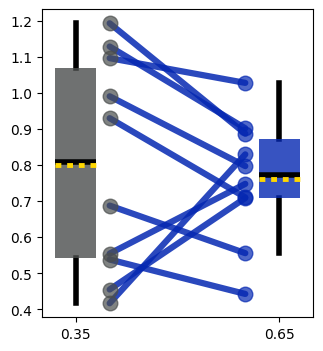

In [273]:
r_means = []
o_means = []
for subject in subjects:
    circ_distances = [np.mean(final_distances[subject]['circ-bl']['NNXr'][uid]) for uid in final_distances[subject]['circ-bl']['NNXr'].keys()]
    reb_distances = [np.mean(final_distances[subject]['rebound']['NNXr'][uid]) for uid in final_distances[subject]['rebound']['NNXr'].keys()]
    r_means.append(np.mean(reb_distances)/np.mean(circ_distances))
    circ_distances = [np.mean(final_distances[subject]['circ-bl']['NNXo'][uid]) for uid in final_distances[subject]['circ-bl']['NNXo'].keys()]
    reb_distances = [np.mean(final_distances[subject]['rebound']['NNXo'][uid]) for uid in final_distances[subject]['rebound']['NNXo'].keys()]
    o_means.append(np.mean(reb_distances)/np.mean(circ_distances))

r_means = np.array(r_means)
o_means = np.array(o_means)
mask = r_means < 20
f, ax = acr.plots.gen_paired_boxplot(r_means[mask], o_means[mask], colors=[NNXR_GRAY, MAIN_COLOR])

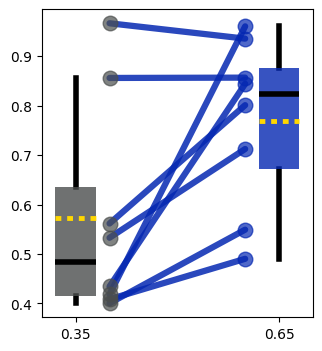

In [276]:
r_means = []
o_means = []
for subject in subjects:
    circ_distances = [np.mean(final_distances[subject]['circ-bl']['NNXr'][uid]) for uid in final_distances[subject]['circ-bl']['NNXr'].keys()]
    reb_distances = [np.mean(final_distances[subject]['rebound']['NNXr'][uid]) for uid in final_distances[subject]['rebound']['NNXr'].keys()]
    r_means.append(np.mean(reb_distances)/np.mean(circ_distances))
    circ_distances = [np.mean(final_distances[subject]['circ-bl']['NNXo'][uid]) for uid in final_distances[subject]['circ-bl']['NNXo'].keys()]
    reb_distances = [np.mean(final_distances[subject]['rebound']['NNXo'][uid]) for uid in final_distances[subject]['rebound']['NNXo'].keys()]
    o_means.append(np.mean(reb_distances)/np.mean(circ_distances))

r_means = np.array(r_means)
o_means = np.array(o_means)
mask = r_means < 1
f, ax = acr.plots.gen_paired_boxplot(r_means[mask], o_means[mask], colors=[NNXR_GRAY, MAIN_COLOR])

In [277]:
pg.ttest(r_means[mask], o_means[mask], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.81487,7,two-sided,0.025964,"[-0.36, -0.03]",0.995697,3.116,0.677155


In [282]:
final_distances = {}
conds = ['circ-bl', 'rebound']
probes = ['NNXo', 'NNXr']
for subject in subjects:
    final_distances[subject] = {}
    for cond in conds:
        if cond == 'circ-bl':
            old_cond = 'circ_bl'
        else:
            old_cond = 'rebound'
        final_distances[subject][cond] = {}
        for probe in probes:
            odf = oodfs[subject].prb(probe).cdn(old_cond)
            starts = odf['start_datetime'].to_numpy()
            ends = odf['end_datetime'].to_numpy()
            prb_df = subject_dataframes[subject].filter(pl.col('probe') == probe).cdn(cond).sort('datetime')
            unit_ids = prb_df['unit_id'].unique().to_numpy()
            unit_ids = np.sort(unit_ids)
            spike_trains = {}
            for unit_id in unit_ids:
                spike_trains[unit_id] = prb_df.filter(pl.col('unit_id') == unit_id)['datetime'].to_numpy()
            spkdistances = {}
            for uid in unit_ids:
                end_inserts = np.searchsorted(spike_trains[uid], ends, side='right')
                end_inserts = np.clip(end_inserts, 0, len(spike_trains[uid])-2)
                nearest_spikes = spike_trains[uid][end_inserts+1]
                spike_distances = nearest_spikes - ends
                spike_distances = spike_distances[spike_distances > np.timedelta64(0, 's')]
                spkdistances[uid] = spike_distances/np.timedelta64(1, 's')
            final_distances[subject][cond][probe] = spkdistances

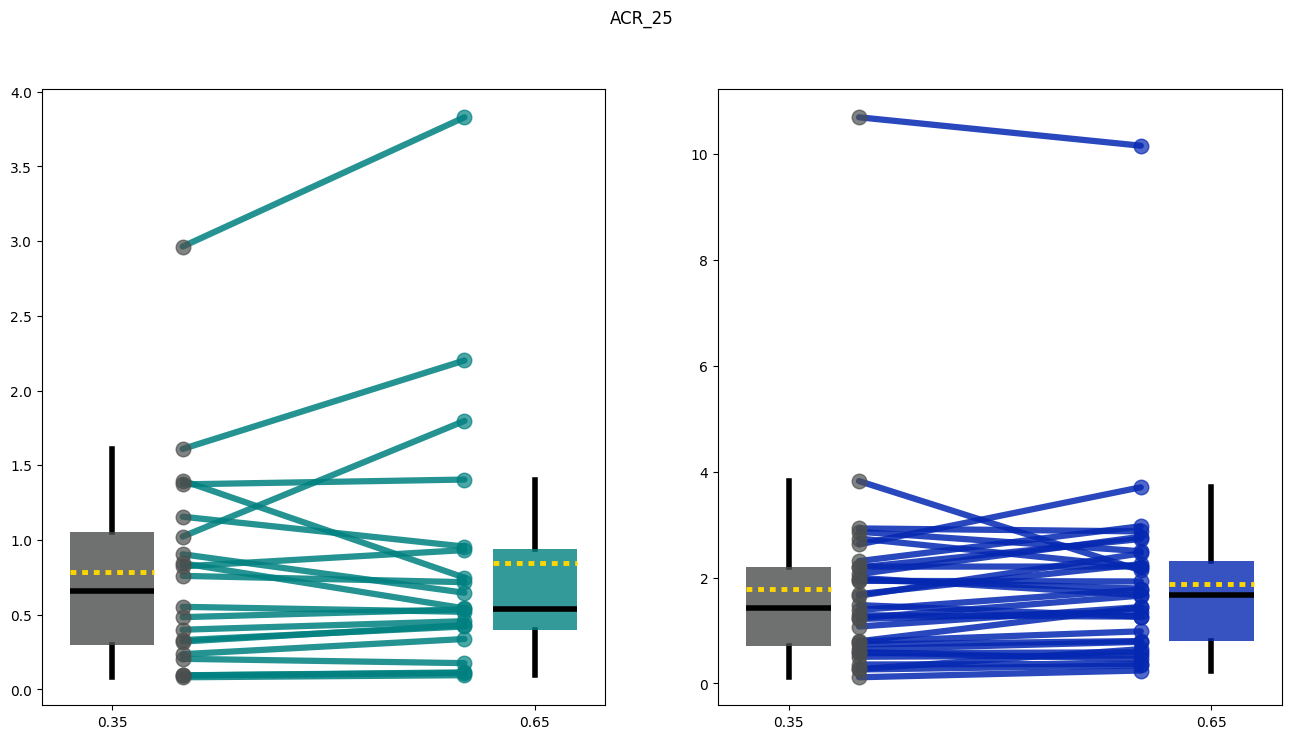

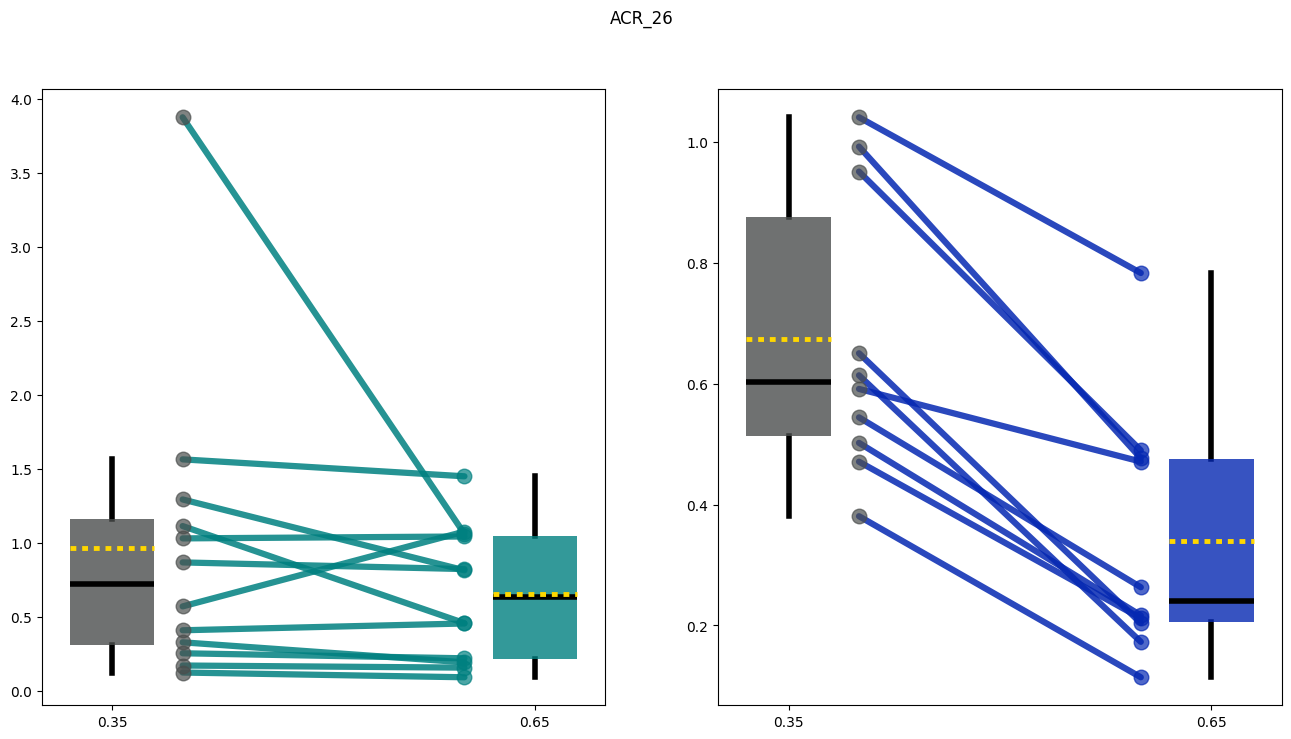

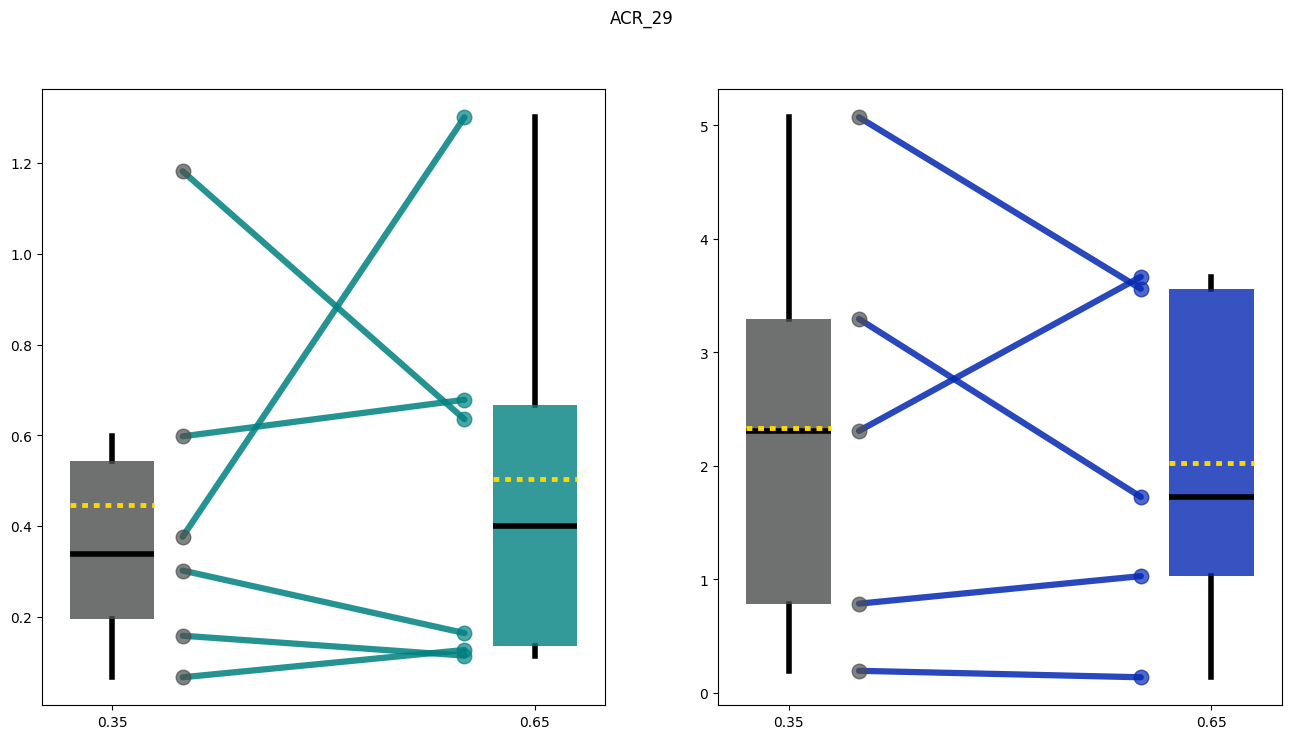

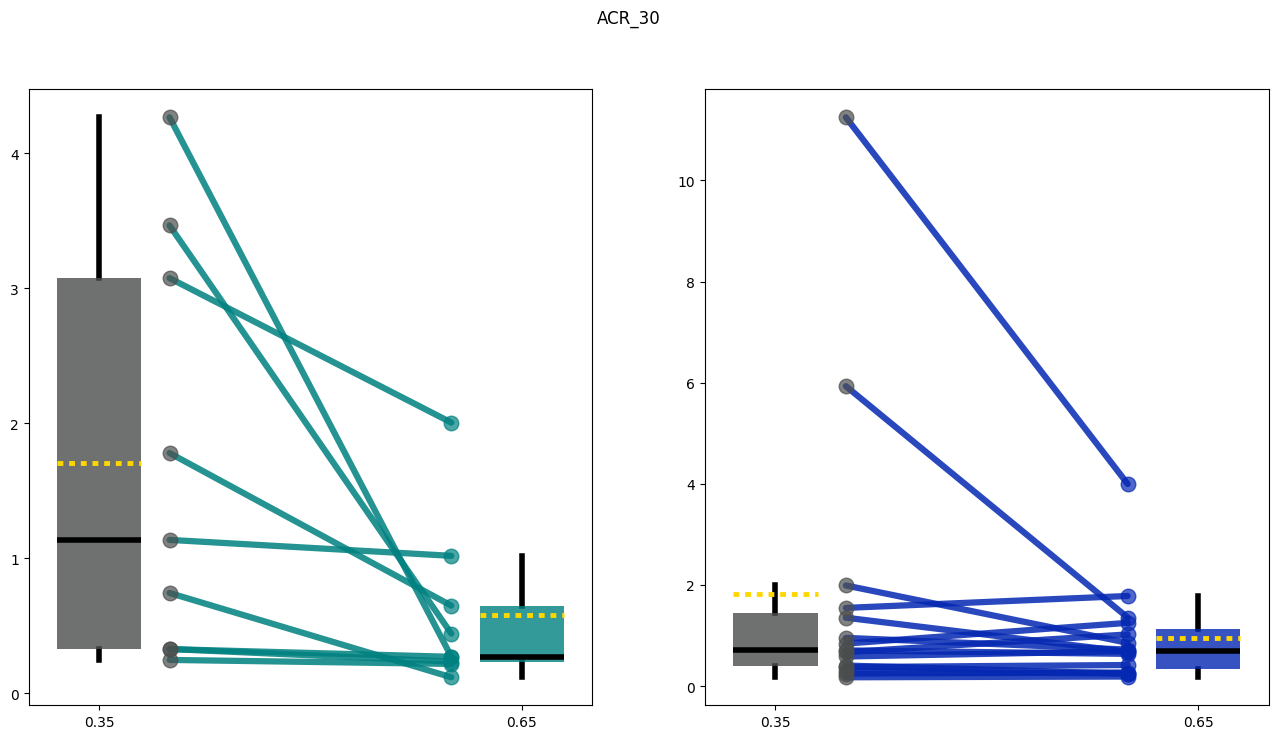

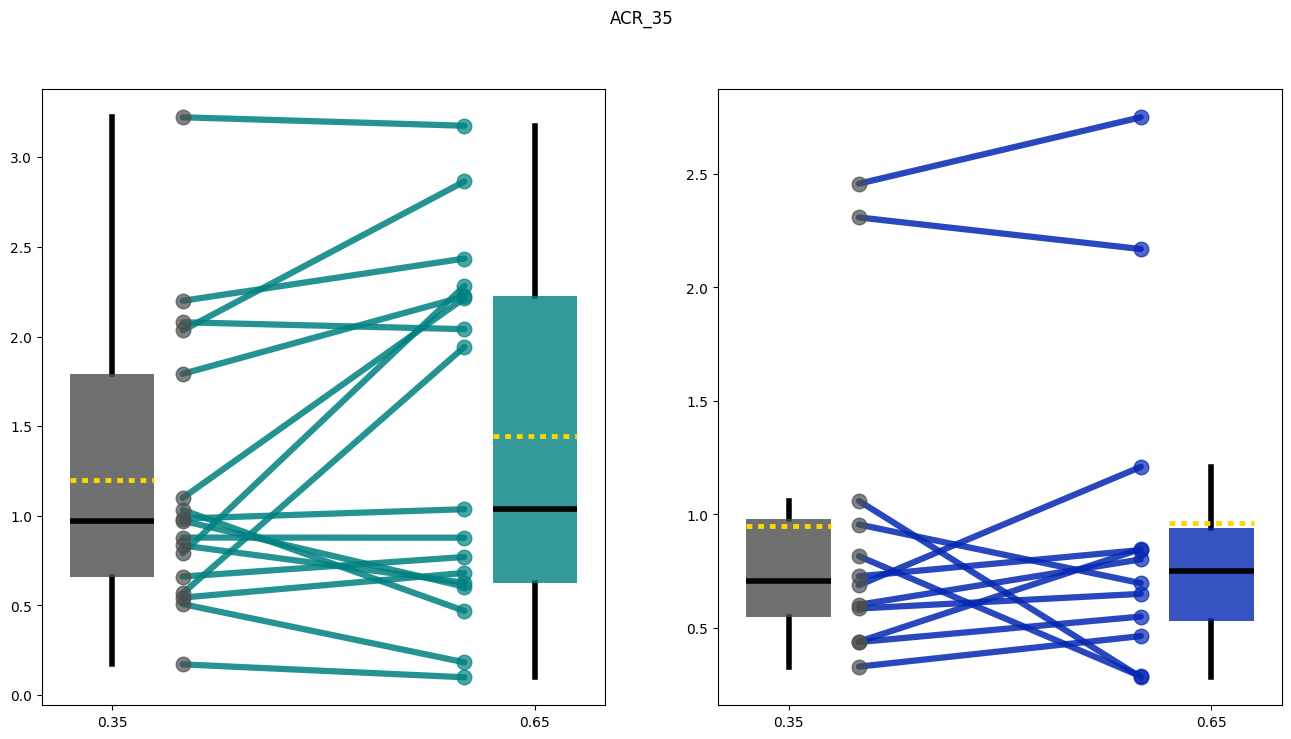

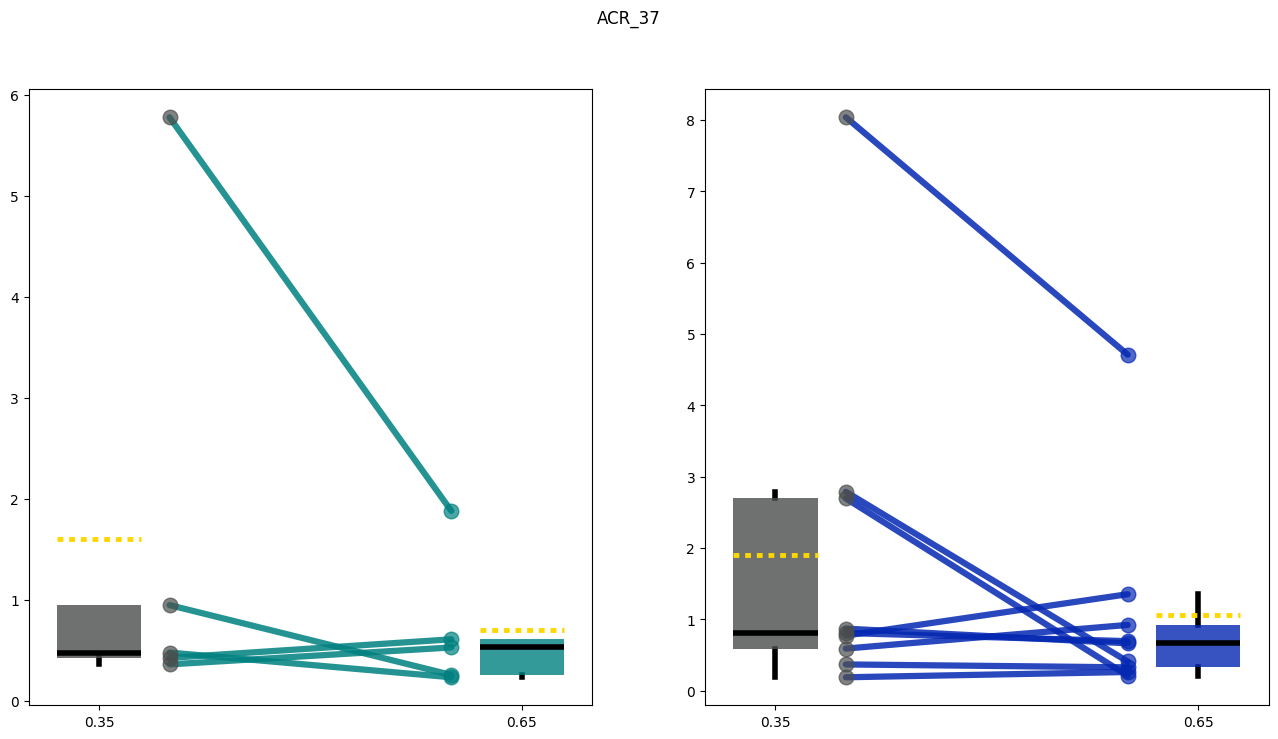

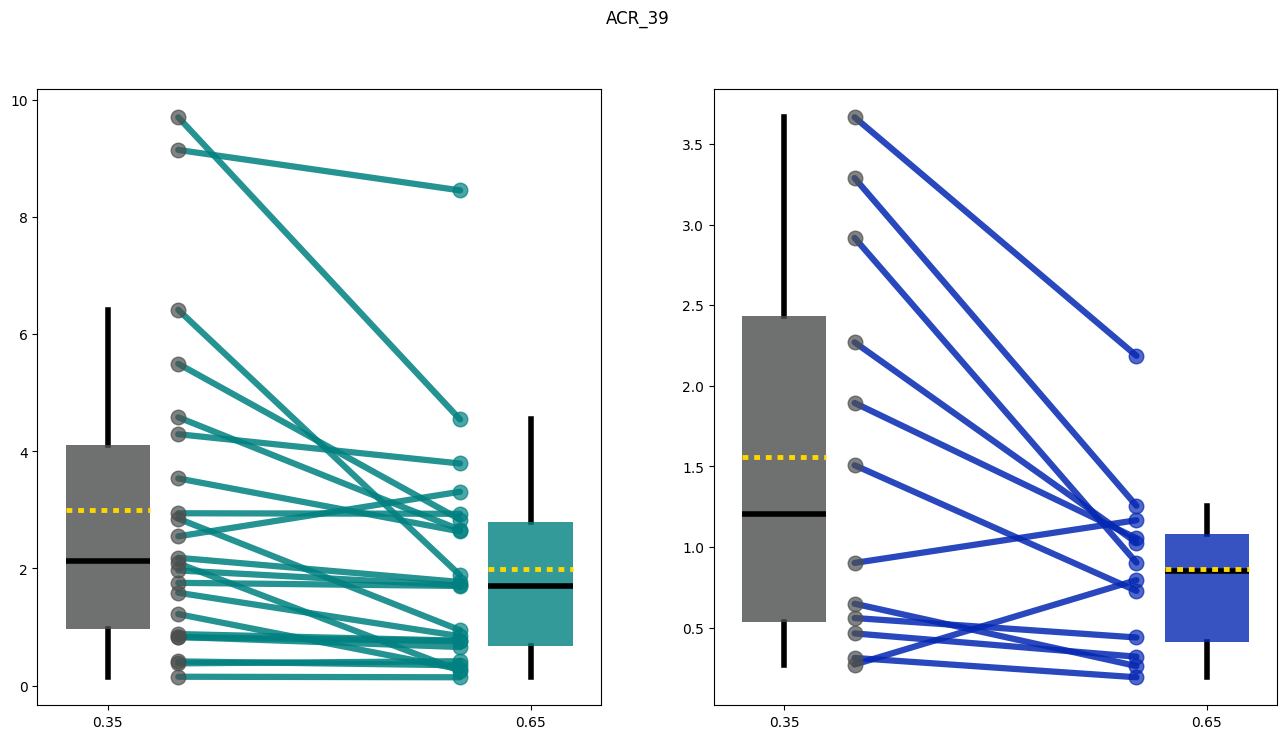

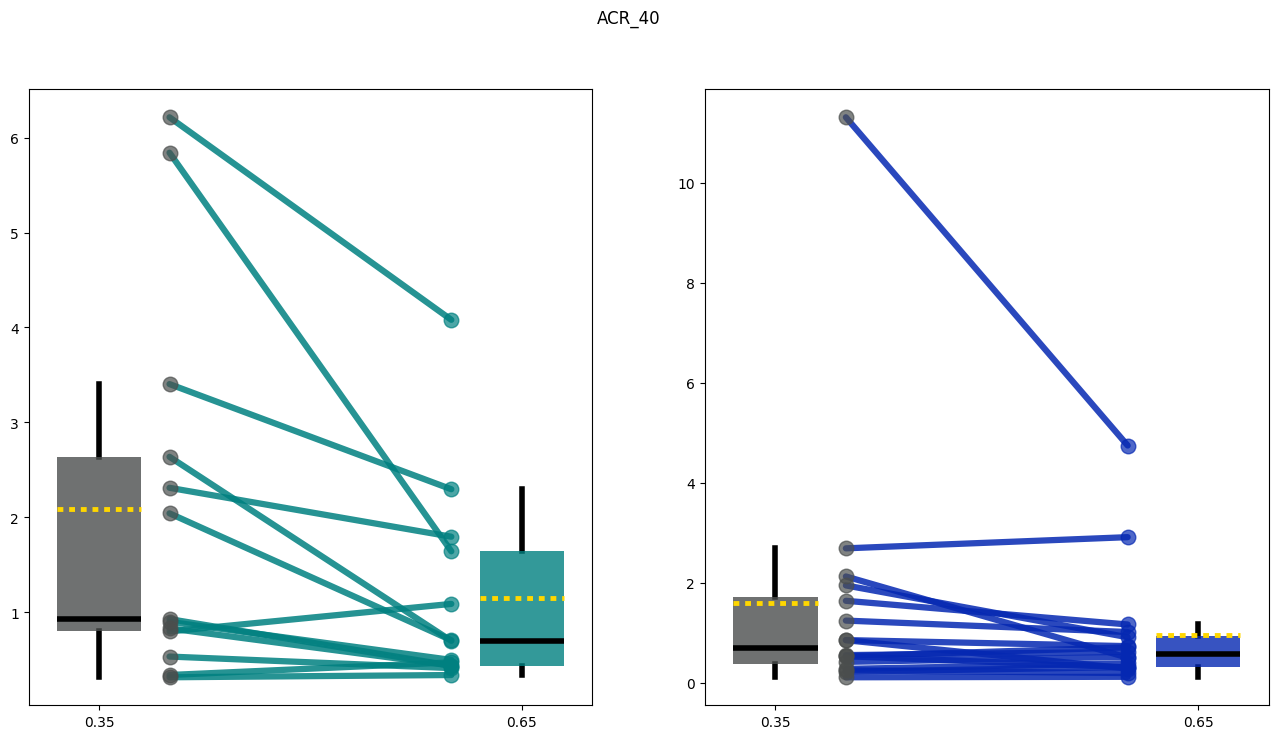

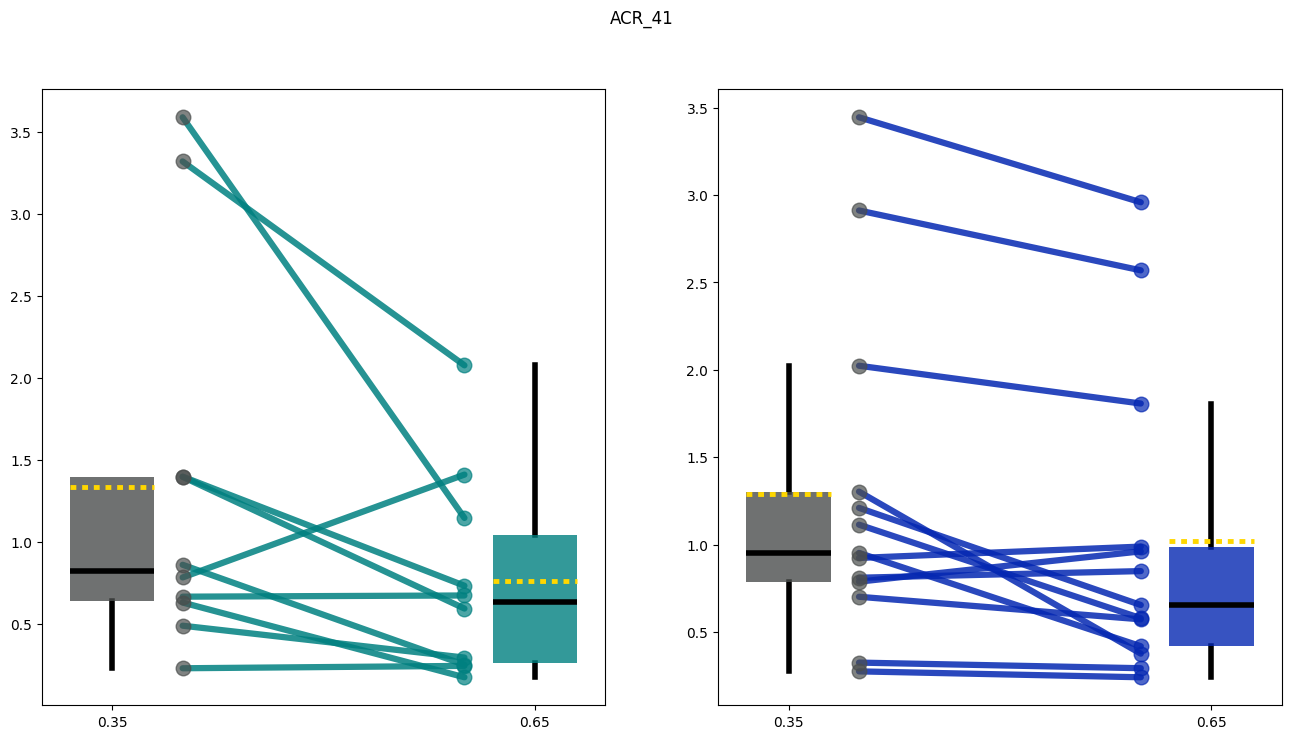

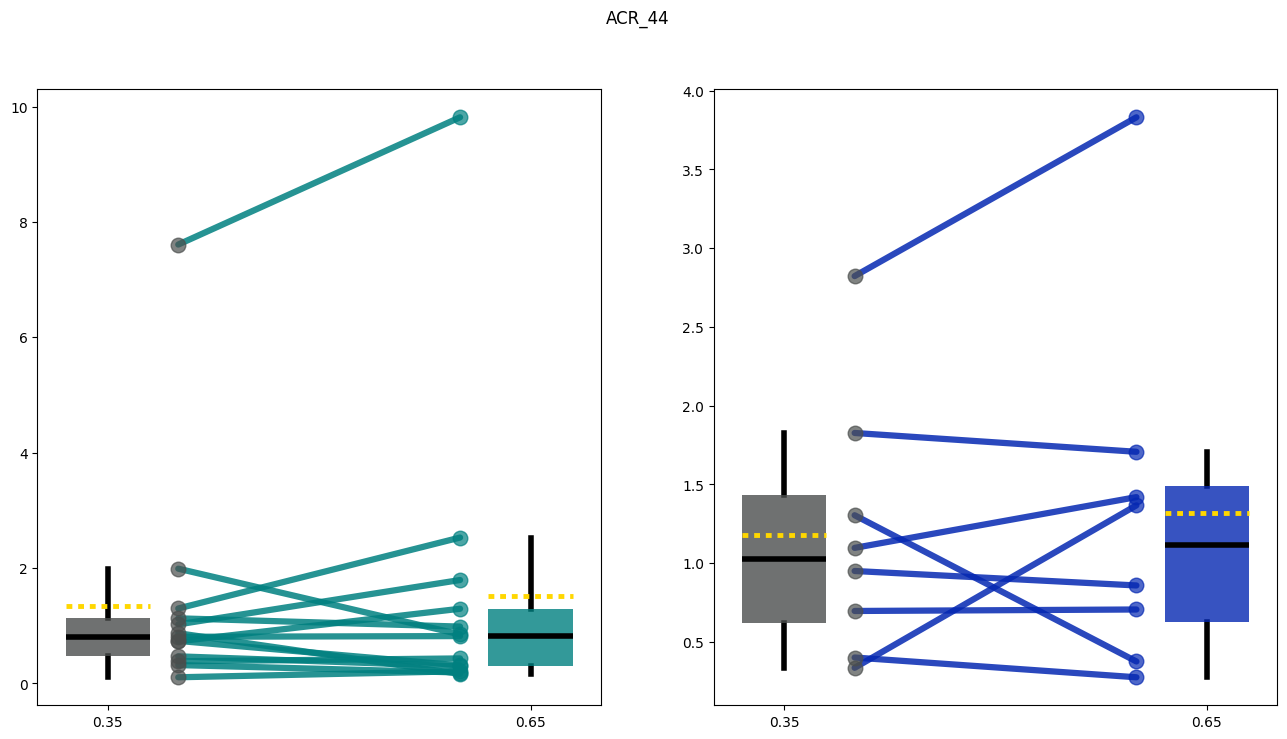

In [283]:
for subject in subjects:
    f, ax = plt.subplots(1, 2, figsize=(16, 8))
    circ_distances = [np.mean(final_distances[subject]['circ-bl']['NNXr'][uid]) for uid in final_distances[subject]['circ-bl']['NNXr'].keys()]
    reb_distances = [np.mean(final_distances[subject]['rebound']['NNXr'][uid]) for uid in final_distances[subject]['rebound']['NNXr'].keys()]
    acr.plots.gen_paired_boxplot(circ_distances, reb_distances, colors=[NNXR_GRAY, 'teal'], ax=ax[0])
    
    circ_distances = [np.mean(final_distances[subject]['circ-bl']['NNXo'][uid]) for uid in final_distances[subject]['circ-bl']['NNXo'].keys()]
    reb_distances = [np.mean(final_distances[subject]['rebound']['NNXo'][uid]) for uid in final_distances[subject]['rebound']['NNXo'].keys()]
    acr.plots.gen_paired_boxplot(circ_distances, reb_distances, ax=ax[1])
    f.suptitle(subject)

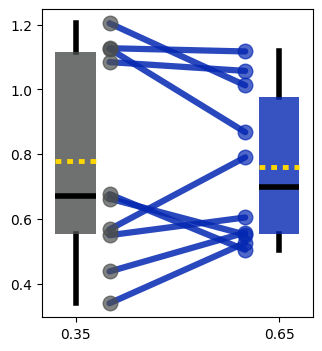

In [285]:
r_means = []
o_means = []
for subject in subjects:
    circ_distances = [np.mean(final_distances[subject]['circ-bl']['NNXr'][uid]) for uid in final_distances[subject]['circ-bl']['NNXr'].keys()]
    reb_distances = [np.mean(final_distances[subject]['rebound']['NNXr'][uid]) for uid in final_distances[subject]['rebound']['NNXr'].keys()]
    r_means.append(np.mean(reb_distances)/np.mean(circ_distances))
    circ_distances = [np.mean(final_distances[subject]['circ-bl']['NNXo'][uid]) for uid in final_distances[subject]['circ-bl']['NNXo'].keys()]
    reb_distances = [np.mean(final_distances[subject]['rebound']['NNXo'][uid]) for uid in final_distances[subject]['rebound']['NNXo'].keys()]
    o_means.append(np.mean(reb_distances)/np.mean(circ_distances))

r_means = np.array(r_means)
o_means = np.array(o_means)
mask = r_means < 10
f, ax = acr.plots.gen_paired_boxplot(r_means[mask], o_means[mask], colors=[NNXR_GRAY, MAIN_COLOR])

In [281]:
pg.ttest(r_means[mask], o_means[mask], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.792282,6,two-sided,0.123263,"[-0.28, 0.04]",0.614951,1.036,0.279174


# Excit_only

In [33]:
for sub in df_filts.keys():
    print(len(df_filts[sub]))

966985
2614158
3574251
2192719
3165750
2794470
2192311


In [46]:
df_filts = {}
ans = {}
qms = {}
for subject, exp in zip(subjects, exps):
    print(subject, exp)
    df_raw, qm, an = acr.ms.load_spike_df_with_qm(subject, exp, sorting_id, return_analyzers=True)
    unts = {}
    filt_dfs = []
    qms[subject] = qm
    for probe in ['NNXo', 'NNXr']:
        qm_probe = qm.prb(probe)        
        unts[probe] = acr.ms.select_good_units(qm_probe.to_pandas(), presence_min=0.95, full_mask=False)
        untsin = unts[probe][0]
        if subject in uidxs.keys():
            if probe in uidxs[subject].keys():
                mask = np.isin(untsin, uidxs[subject][probe])
                untsin = untsin[~mask]
        df_probe = df_raw.filter((pl.col('probe') == probe)&(pl.col('unit_id').is_in(untsin)))
        filt_dfs.append(df_probe)
    qms[subject] = qms[subject].with_columns(pl.lit(subject).alias('subject'))
    df = pl.concat(filt_dfs)
    rt_sub = rate_types.filter(pl.col('subject')==subject)
    df = df.with_columns(pl.lit(subject).alias('subject'))
    df = df.join(rt_sub, on=['subject', 'probe', 'unit_id'], how='left')
    df = df.filter(pl.col('cell_type')=='pyr')
    df_filts[subject] = df
    
    ans[subject] = an

ACR_17 swi
ACR_18 swi
ACR_19 swi2
ACR_23 swi2
ACR_31 swi2
ACR_33 swi
ACR_34 swi


In [47]:
for sub in df_filts.keys():
    print(len(df_filts[sub]))

966985
2108384
2537460
1880883
2663033
2502651
1784403


In [48]:
df_counts = []
for subject in df_filts.keys():
    dc = df_filts[subject].group_by('probe').agg(pl.col('unit_id').unique().count())
    dc = dc.to_pandas()
    dc['subject'] = subject
    dc['sub_type'] = SUBJECT_TYPE
    df_counts.append(dc)
df_count = pd.concat(df_counts)
df_count.to_parquet(f'{SUBJECT_TYPE}_dfcounts_excit.parquet')

In [49]:
cond_dfs = {}
spike_trains = {}
sttcs = {}
for subject in df_filts.keys():
    cond_dfs[subject] = {}
    times = [
        (0, 3600),
        (3600, 7200),
        (7200, 10800)
    ]
    for tt, cond in zip(times, ['early_bl', 'circ_bl', 'rebound']):
        cond_df = df_filts[subject].filter((pl.col('time')>=tt[0])&(pl.col('time')<tt[1]))
        dftimes = cond_df['time'].to_numpy()
        times_rel = dftimes - tt[0]
        cond_df = cond_df.with_columns(pl.lit(times_rel).alias('time_rel'))
        cond_dfs[subject][cond] = cond_df
for subject in df_filts.keys():
    spike_trains[subject] = {}
    for cond in cond_dfs[subject]:
        spike_trains[subject][cond] = {}
        for probe in ['NNXo', 'NNXr']:
            spike_trains[subject][cond][probe] = []
            uids = cond_dfs[subject][cond].prb(probe)['unit_id'].unique().to_numpy()
            uids = np.sort(uids)
            for uid in uids:
                spike_trains[subject][cond][probe].append(cond_dfs[subject][cond].prb(probe).filter(pl.col('unit_id') == uid)['time_rel'].to_numpy())
for subject in spike_trains.keys():
    sttcs[subject] = {}
    for cond in spike_trains[subject].keys():
        sttcs[subject][cond] = {}
        for probe in spike_trains[subject][cond].keys():
            sttcs[subject][cond][probe] = acr.sync.sttc_matrix_fast(spike_trains[subject][cond][probe], 0, 3600, .005)

# Subject - Level STTC

In [50]:
reb_rels_hom = {}
for subject in spike_trains.keys():
    reb_rels_hom[subject] = {}
    for probe in ['NNXr', 'NNXo']:
        hom = sttcs[subject]['early_bl'][probe] - sttcs[subject]['circ_bl'][probe]
        mask = hom > 0.0
        # where mask is false, set hom to nan
        hom[~mask] = np.nan
        
        eps = 1e-6
        cbl_mtx = np.arctanh(np.clip(sttcs[subject]['circ_bl'][probe], -1+eps, 1-eps))
        reb_mtx = np.arctanh(np.clip(sttcs[subject]['rebound'][probe], -1+eps, 1-eps))
        
        reb_rel = reb_mtx - cbl_mtx
        reb_rel[~mask] = np.nan
        reb_rels_hom[subject][probe] = reb_rel
nnxo = np.array([np.nanmean(reb_rels_hom[subject]['NNXo']) for subject in reb_rels_hom.keys()])
nnxr = np.array([np.nanmean(reb_rels_hom[subject]['NNXr']) for subject in reb_rels_hom.keys()])

In [51]:
reb_rels_fixed = {}
for subject in spike_trains.keys():
    reb_rels_fixed[subject] = {}
    for probe in ['NNXr', 'NNXo']:
        hom = sttcs[subject]['early_bl'][probe] - sttcs[subject]['circ_bl'][probe]
        mask = hom <= 0.0
        # where mask is false, set hom to nan
        hom[~mask] = np.nan
        
        eps = 1e-6
        cbl_mtx = np.arctanh(np.clip(sttcs[subject]['circ_bl'][probe], -1+eps, 1-eps))
        reb_mtx = np.arctanh(np.clip(sttcs[subject]['rebound'][probe], -1+eps, 1-eps))
        
        reb_rel = reb_mtx - cbl_mtx
        reb_rel[~mask] = np.nan
        reb_rels_fixed[subject][probe] = reb_rel
nnxo = np.array([np.nanmean(reb_rels_fixed[subject]['NNXo']) for subject in reb_rels_fixed.keys()])
nnxr = np.array([np.nanmean(reb_rels_fixed[subject]['NNXr']) for subject in reb_rels_fixed.keys()])

# Single Unit-Level STTC

In [52]:
cond_dfs = {}
spike_trains = {}
sttcs = {}
for subject in df_filts.keys():
    cond_dfs[subject] = {}
    times = [
        (0, 3600),
        (3600, 7200),
        (7200, 10800)
    ]
    for tt, cond in zip(times, ['early_bl', 'circ_bl', 'rebound']):
        cond_df = df_filts[subject].filter((pl.col('time')>=tt[0])&(pl.col('time')<tt[1]))
        dftimes = cond_df['time'].to_numpy()
        times_rel = dftimes - tt[0]
        cond_df = cond_df.with_columns(pl.lit(times_rel).alias('time_rel'))
        cond_dfs[subject][cond] = cond_df
for subject in df_filts.keys():
    spike_trains[subject] = {}
    for cond in cond_dfs[subject]:
        spike_trains[subject][cond] = {}
        for probe in ['NNXo', 'NNXr']:
            spike_trains[subject][cond][probe] = []
            uids = cond_dfs[subject][cond].prb(probe)['unit_id'].unique().to_numpy()
            uids = np.sort(uids)
            for uid in uids:
                spike_trains[subject][cond][probe].append(cond_dfs[subject][cond].prb(probe).filter(pl.col('unit_id') == uid)['time_rel'].to_numpy())
for subject in spike_trains.keys():
    sttcs[subject] = {}
    for cond in spike_trains[subject].keys():
        sttcs[subject][cond] = {}
        for probe in spike_trains[subject][cond].keys():
            sttcs[subject][cond][probe] = acr.sync.sttc_matrix_fast(spike_trains[subject][cond][probe], 0, 3600, .005)

In [53]:
# Homeostatically regulated unit pairs
ubu_hom = {}
ubudf_hom = {}
ubudf_hom['NNXo'] = []
ubudf_hom['NNXr'] = []
for subject in spike_trains.keys():
    ubu_hom[subject] = {}
    for probe in ['NNXo', 'NNXr']:
        hom = sttcs[subject]['early_bl'][probe] - sttcs[subject]['circ_bl'][probe]
        mask = hom > 0.0
        ebl = sttcs[subject]['early_bl'][probe]
        cbl = sttcs[subject]['circ_bl'][probe]
        reb = sttcs[subject]['rebound'][probe]
        ebl[~mask] = np.nan
        cbl[~mask] = np.nan
        reb[~mask] = np.nan
        cbl_df = acr.stats.get_positions_and_values_df(cbl, 'sttc_late', subject)
        reb_df = acr.stats.get_positions_and_values_df(reb, 'sttc_rebound', subject)
        reb_df = reb_df.merge(cbl_df, on=['mouse', 'unit_i', 'unit_j'], how='inner')
        reb_df['probe'] = probe
        ubudf_hom[probe].append(reb_df)
ubudf_hom['NNXo'] = pd.concat(ubudf_hom['NNXo'])
ubudf_hom['NNXr'] = pd.concat(ubudf_hom['NNXr'])
main_ubudf_hom = pd.concat(ubudf_hom.values())
main_ubudf_hom['probe'] = main_ubudf_hom['probe'].replace({'NNXo': 'optrode', 'NNXr': 'contra'})
dz = acr.stats.fisher_z(main_ubudf_hom["sttc_rebound"].to_numpy()) - acr.stats.fisher_z(main_ubudf_hom["sttc_late"].to_numpy())
main_ubudf_hom["dz"] = dz

In [54]:
main_ubudf_hom.to_csv('dfacr_excit.csv', index=False)

In [55]:
cond_dfs = {}
spike_trains = {}
sttcs = {}
for subject in df_filts.keys():
    cond_dfs[subject] = {}
    times = [
        (0, 3600),
        (3600, 7200),
        (7200, 10800)
    ]
    for tt, cond in zip(times, ['early_bl', 'circ_bl', 'rebound']):
        cond_df = df_filts[subject].filter((pl.col('time')>=tt[0])&(pl.col('time')<tt[1]))
        dftimes = cond_df['time'].to_numpy()
        times_rel = dftimes - tt[0]
        cond_df = cond_df.with_columns(pl.lit(times_rel).alias('time_rel'))
        cond_dfs[subject][cond] = cond_df
for subject in df_filts.keys():
    spike_trains[subject] = {}
    for cond in cond_dfs[subject]:
        spike_trains[subject][cond] = {}
        for probe in ['NNXo', 'NNXr']:
            spike_trains[subject][cond][probe] = []
            uids = cond_dfs[subject][cond].prb(probe)['unit_id'].unique().to_numpy()
            uids = np.sort(uids)
            for uid in uids:
                spike_trains[subject][cond][probe].append(cond_dfs[subject][cond].prb(probe).filter(pl.col('unit_id') == uid)['time_rel'].to_numpy())
for subject in spike_trains.keys():
    sttcs[subject] = {}
    for cond in spike_trains[subject].keys():
        sttcs[subject][cond] = {}
        for probe in spike_trains[subject][cond].keys():
            sttcs[subject][cond][probe] = acr.sync.sttc_matrix_fast(spike_trains[subject][cond][probe], 0, 3600, .005)

In [56]:
# FIXED unit pairs
ubu_fix = {}
ubudf_fix = {}
ubudf_fix['NNXo'] = []
ubudf_fix['NNXr'] = []
for subject in spike_trains.keys():
    ubu_fix[subject] = {}
    for probe in ['NNXo', 'NNXr']:
        print(subject, probe)
        hom = sttcs[subject]['early_bl'][probe] - sttcs[subject]['circ_bl'][probe]
        mask = hom <= 0.0
        ebl = sttcs[subject]['early_bl'][probe]
        cbl = sttcs[subject]['circ_bl'][probe]
        reb = sttcs[subject]['rebound'][probe]
        ebl[~mask] = np.nan
        cbl[~mask] = np.nan
        reb[~mask] = np.nan
        cbl_df = acr.stats.get_positions_and_values_df(cbl, 'sttc_late', subject)
        reb_df = acr.stats.get_positions_and_values_df(reb, 'sttc_rebound', subject)
        reb_df = reb_df.merge(cbl_df, on=['mouse', 'unit_i', 'unit_j'], how='inner')
        reb_df['probe'] = probe
        ubudf_fix[probe].append(reb_df)
ubudf_fix['NNXo'] = pd.concat(ubudf_fix['NNXo'])
ubudf_fix['NNXr'] = pd.concat(ubudf_fix['NNXr'])
main_ubudf_fix = pd.concat(ubudf_fix.values())
main_ubudf_fix['probe'] = main_ubudf_fix['probe'].replace({'NNXo': 'optrode', 'NNXr': 'contra'})
dz = acr.stats.fisher_z(main_ubudf_fix["sttc_rebound"].to_numpy()) - acr.stats.fisher_z(main_ubudf_fix["sttc_late"].to_numpy())
main_ubudf_fix["dz"] = dz

ACR_17 NNXo
ACR_17 NNXr
ACR_18 NNXo
ACR_18 NNXr
ACR_19 NNXo
ACR_19 NNXr
ACR_23 NNXo
ACR_23 NNXr
ACR_31 NNXo
ACR_31 NNXr
ACR_33 NNXo
ACR_33 NNXr
ACR_34 NNXo
ACR_34 NNXr


In [57]:
main_ubudf_fix.to_csv('dfacr_fix_excit.csv', index=False)